# Text Summarization

In [1]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split 
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My\ Drive/Text\ Summarizer

/content/drive/My Drive/Text Summarizer


# Preparing and Loading Data

In [4]:
# !wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/18%2F2157%2Fcompressed%2FReviews.csv.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1592829433&Signature=Rcvu965Hen%2FP1g8g%2FXWoV3SQgI4FONM6EAig43QKnI8IVcOfX7vEr9mBZxez9S%2FIuE3cCixcweoyusegUYBvofd6Wnwooxft5z6G6yYAWtBnoUU7x7rH3%2BvEtDfmu4t8hMH7R%2Ftv9NML4BT9TylAmBq7hGWGDTnKn6nOdL8dWxugdV1X1zoJ4hizkuAE13CrPZPhMFDucTkmxOswb7Er9yyzCmkr8yzXzjm35eYON%2FWlhJ%2FjfnImIBJvQyWJ%2BLAer5NWepR5cX7afq5FRklDEQLs3JjA4SSxNdGZ%2BncUx824LCnQXjUZCPcGhFmlUkX9LNa6yOAj%2B50tQ1ZUjnnfdg%3D%3D" -c -O '18_2157_compressed_Reviews.csv.zip'

In [ ]:
# import zipfile
# with zipfile.ZipFile('Reviews.csv.zip', 'r') as zip_ref:
#     zip_ref.extractall("./")

In [5]:
data=pd.read_csv("Reviews.csv",nrows=200000)

In [6]:
data.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
40541,40542,B00020HHRW,A16QUBP9J1KSDM,"Martha G. Huebert ""retired teacher""",4,10,3,1195171200,"tea OK, postage way too high","The sage tea is OK, but I was surprised that f..."
77518,77519,B002EYBB3A,A1J5HIF41ENSMZ,Adam Wood,16,16,5,1276300800,High quality tuna that's easier on my conscience,I originally tried Wild Planet tuna back in 20...
7682,7683,B001E5DZTS,A3NE8L23J9GHC1,M. L. Lopez,5,5,5,1190592000,My daughter loves this milk!,My 14 month old daughter can not tolerate cows...
185397,185398,B001AHFVHO,A3JV071KO43Q5X,"Jeff Pittman ""Jeff""",0,0,3,1220140800,Somewhere between a Frito and a tortilla chip,...but I guess a little more like a tortilla c...
66466,66467,B002HQFN9I,A1XV49PJK0AP7C,Bizobb,0,0,5,1321920000,My favorite!,"Level 4 is what used to be their ""Breakfast Bl..."


In [7]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

### Preprocessing

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:                                               
        long_words.append(i)   
    return "startseq " + (" ".join(long_words)).strip() + " endseq"

In [11]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,1))

In [12]:
cleaned_text[:5]

['startseq i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most endseq',
 'startseq product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo endseq',
 'startseq this is a confection that has been around a few centuries it is a light pillowy citrus gelatin with nuts in this case filberts and it is cut into tiny squares and then liberally coated with powdered sugar and it is a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you are familiar with the story of c s lewis the lion the witch and the wardrobe this is the treat that seduces edmund into selling out his brother and sisters to the witch endseq',
 'startse

In [13]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b000v9lq30/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/u

In [14]:
cleaned_summary[:5]

['startseq good quality dog food endseq',
 'startseq not as advertised endseq',
 'startseq delight says it all endseq',
 'startseq cough medicine endseq',
 'startseq great taffy endseq']

In [15]:
data = pd.DataFrame({'text' : cleaned_text, 'summary' : cleaned_summary})

In [16]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [17]:
data.head()

,text,summary
0,startseq i have bought several of the vitality...,startseq good quality dog food endseq
1,startseq product arrived labeled as jumbo salt...,startseq not as advertised endseq
2,startseq this is a confection that has been ar...,startseq delight says it all endseq
3,startseq if you are looking for the secret ing...,startseq cough medicine endseq
4,startseq great taffy at a great price there wa...,startseq great taffy endseq


In [18]:
cnt=0
for i in data['text']:
    if(len(i.split())<=300):
        cnt=cnt+1
print(cnt/len(data['text']))

0.9814535047962956


In [19]:
cnt=0
for i in data['summary']:
    if(len(i.split())<=20):
        cnt=cnt+1
print(cnt/len(data['summary']))

0.9989437095446897


In [20]:
max_text_len=300
max_summary_len=20

# Train Test Split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data['text'], data['summary'],  train_size=0.8)

# Tokenization


In [22]:
def pad_sequence(t, padding_var = 20):
    t = sequence.pad_sequences(t, maxlen=padding_var, padding='post') 
    return t

def build_data(train, test, padding_var):
  print("="*100)
  print("Fitting the Tokenizer...")
  tokenizer = Tokenizer(lower=True)
  tokenizer.fit_on_texts(train)
  print("Done...")
  print('Found %s unique tokens.' % len(tokenizer.word_counts))
  print("="*100)
  print()
  print("Processing Text to sequence process")
  train = tokenizer.texts_to_sequences(train)
  test = tokenizer.texts_to_sequences(test)
  print("Done")
  print("="*100)
  print()
  print("Starting Padding Process...")  
  train = pad_sequence(train, padding_var)
  test = pad_sequence(test, padding_var)
  print("Done")
  return train, test, tokenizer

## Text Tokenization

In [23]:
X_train, X_test, tokenizer_X = build_data(X_train, X_test, max_text_len)

Fitting the Tokenizer...
Done...
Found 67960 unique tokens.

Processing Text to sequence process
Done

Starting Padding Process...
Done


## Summary Tokenization

In [24]:
Y_train, Y_test, tokenizer_Y = build_data(Y_train, Y_test, max_summary_len)

Fitting the Tokenizer...
Done...
Found 18422 unique tokens.

Processing Text to sequence process
Done

Starting Padding Process...
Done


In [25]:
num_encoder_tokens = len(tokenizer_X.word_counts)
num_decoder_tokens = len(tokenizer_Y.word_counts)+1
num_encoder_tokens, num_decoder_tokens

(67960, 18423)

# Processing Embedding Matrix¶

In [26]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=d7b5ff0d1f90d1c7a377b489364c4ada42047d093e37fa3738890c19d364e373
  Stored in directory: /tmp/pip-ephem-wheel-cache-cgydbab7/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [27]:
import en_core_web_lg
text_word_vectos = en_core_web_lg.load() 

In [28]:
def build_embedding_matrix(tokenizer):
    embedding_matrix = np.zeros((len(tokenizer.word_counts) + 1, 300))

    for word, i in tokenizer.word_index.items():  
        embedding_matrix[i] = text_word_vectos(word).vector
    
    return embedding_matrix 
embedding_matrix_enc = build_embedding_matrix(tokenizer_X)
embedding_matrix_dec = build_embedding_matrix(tokenizer_Y)

In [29]:
embedding_matrix_enc.shape, embedding_matrix_dec.shape

((67961, 300), (18423, 300))

# Defining The Model


In [31]:
from attention import AttentionLayer

In [32]:
def build_model(latent_dim=256):

    embedding_enc = Embedding(*embedding_matrix_enc.shape, weights=[embedding_matrix_enc], trainable=False, mask_zero=True, name = "Encoder_Embedding")
    embedding_dec = Embedding(*embedding_matrix_dec.shape, weights=[embedding_matrix_dec], trainable=False, mask_zero=True, name = "Decoder_Embedding")
    
    """ Encoder LSTM""" 
    encoder_inputs = Input(shape=(max_text_len,), name="encoder_input")
    enc_emb = embedding_enc(encoder_inputs) 
    enc_output, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, name = "Encoder_biLSTM"))(enc_emb)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
     
    encoder_states = [state_h, state_c]
    

    """ Decoder LSTM """ 
    decoder_inputs = Input(shape=(max_summary_len,), name="decoder_input")
    dec_emb_layer = embedding_dec(decoder_inputs)
    dec_lstm = LSTM(2*latent_dim, return_sequences=True, return_state=True, name = "Decoder_LSTM")
    
    decoder_outputs, state_h, state_c = dec_lstm(dec_emb_layer,initial_state=encoder_states)
     
    decoder_states = [state_h, state_c] 
     
    """ Attention Layer """
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([enc_output, decoder_outputs])
    
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
    
    dense = Dense(num_decoder_tokens, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_concat_input)

    """ Defining Full Model """
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs = decoder_pred) 
    
    
    
    
    """ Defining Inference Model """ 
    
    # Encoder Model
     
    encoder_model = Model(inputs = encoder_inputs, outputs = [enc_output, encoder_states])
     
    """ Decoder Model """
     
    decoder_states_inputs = [Input(shape=(2*latent_dim,), name = "Decoder_inp_1"), Input(shape=(2*latent_dim,), name = "Decoder_inp_2")]
    enc_output = Input(shape=(max_text_len, 2*latent_dim), name = "encoder_output")

    # To predict the next word in the sequence, set the initial states to the states from the previous time step
    decoder_outputs, state_h, state_c = dec_lstm(dec_emb_layer, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    
    attn_out, attn_states = attn_layer([enc_output, decoder_outputs])
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
    
    decoder_pred = dense_time(decoder_concat_input)     
    decoder_model = Model( [enc_output, decoder_states_inputs, decoder_inputs], [decoder_pred, attn_states, decoder_states])    
    
    
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    return model, encoder_model, decoder_model

In [33]:
model, encoder_model, decoder_model = build_model()

Model Architecture


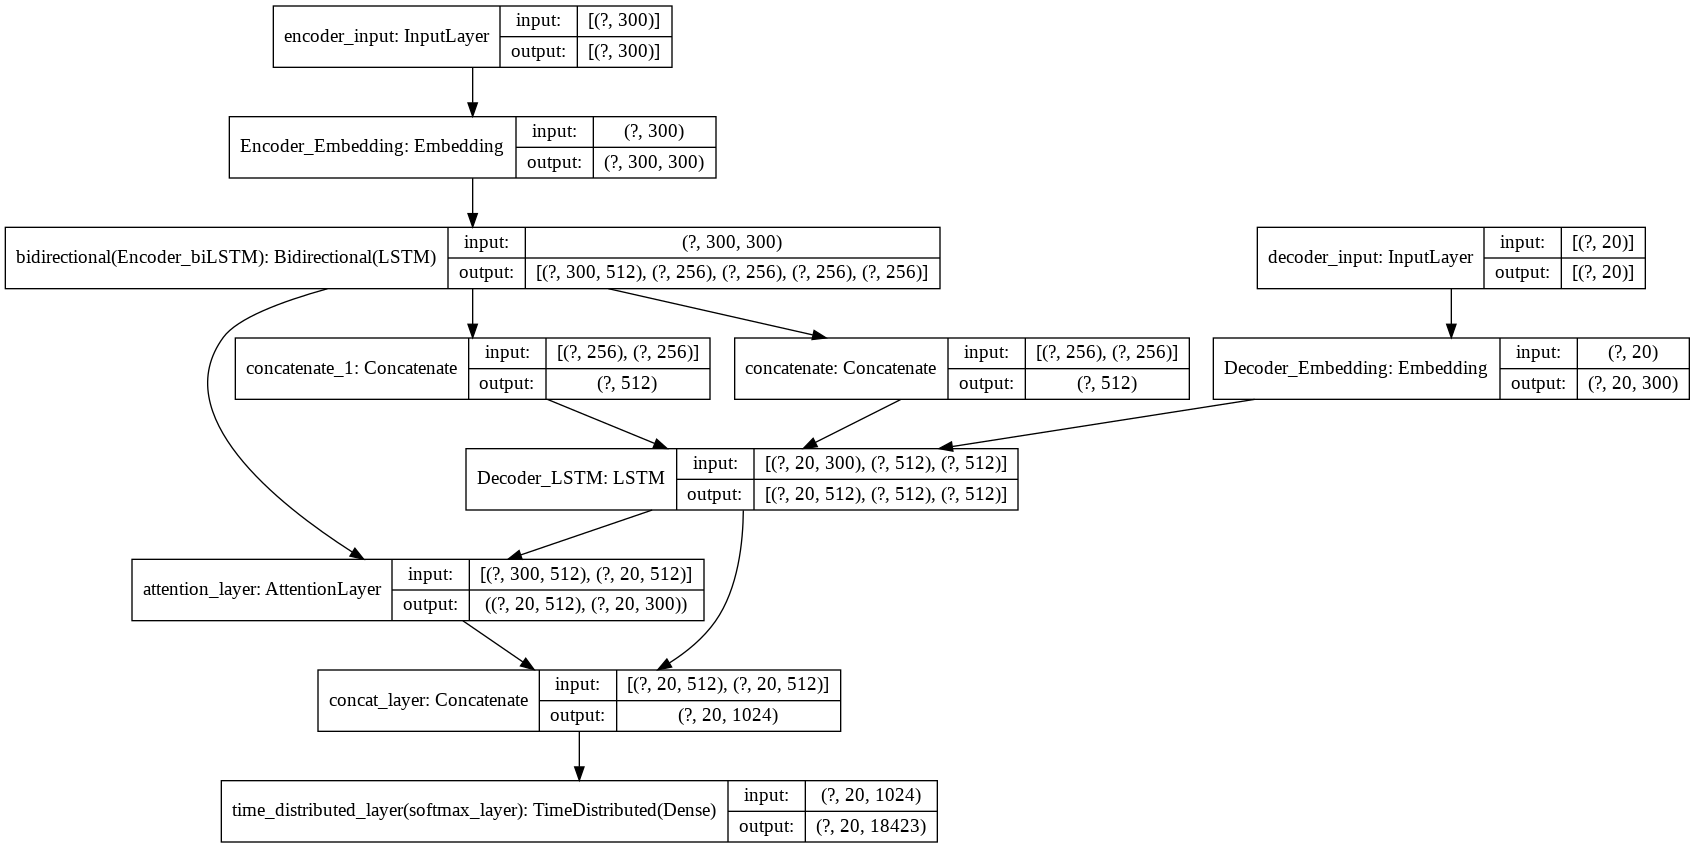

In [34]:
print("Model Architecture")
plot_model(model, to_file='model_architectures/model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

Encoder Model Architecture


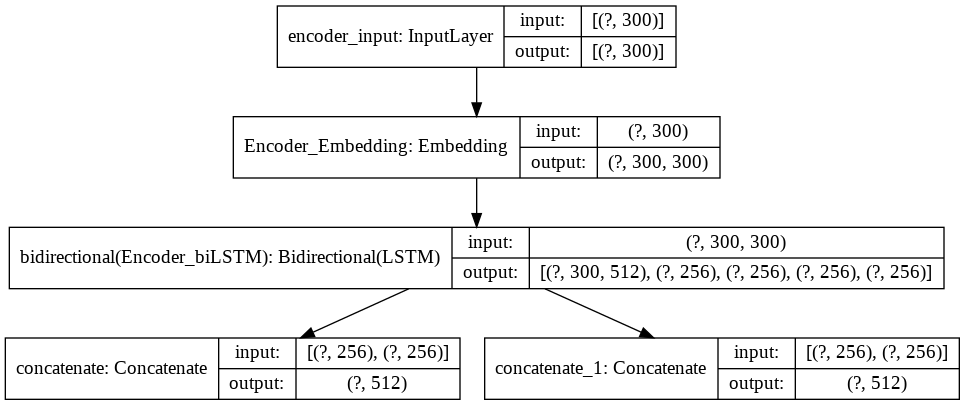

In [35]:
print("Encoder Model Architecture")
plot_model(encoder_model, to_file='model_architectures/encoder_model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

Decoder Model Architecture


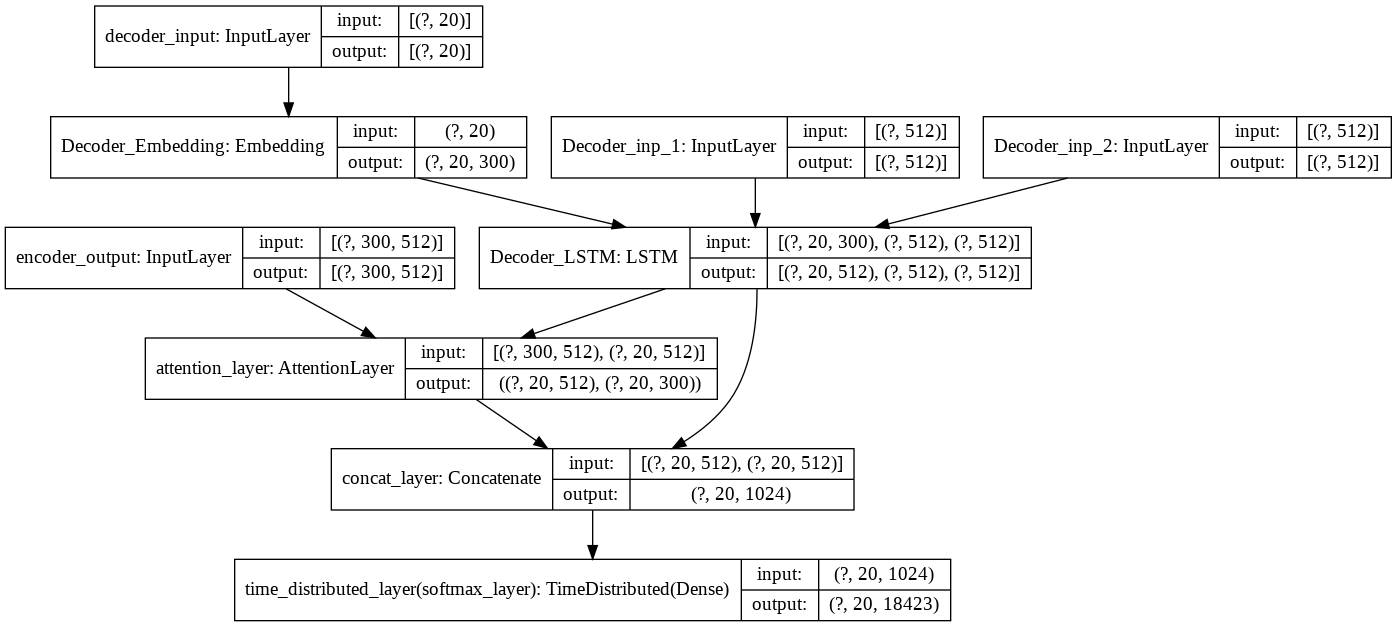

In [36]:
print("Decoder Model Architecture")
plot_model(decoder_model, to_file='model_architectures/decoder_model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [37]:
def generate_batch(X, y, batch_size):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.array(X[j:j+batch_size])
            decoder_input_data = np.array(y[j:j+batch_size])
            decoder_target_data = np.zeros((encoder_input_data.shape[0], max_summary_len, num_decoder_tokens),dtype='float32')
            for i, target_text in enumerate(y[j:j+batch_size]):
                for t, index in enumerate(target_text):
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        decoder_target_data[i, t - 1, index] = 1.
           
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [51]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 64
epochs = 5
train_samples, val_samples

(130267, 32567)

In [39]:
filepath="model/weights-improvement-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [52]:
model.fit_generator(generator = generate_batch(X_train, Y_train, batch_size = batch_size),
  steps_per_epoch = len(X_train)//batch_size,
  epochs=epochs,
  validation_data = generate_batch(X_test, Y_test, batch_size = batch_size),
  validation_steps = len(X_test)//batch_size , callbacks = callbacks_list
)

Epoch 1/5
2035/2035 [==============================] - 1712s 841ms/step - loss: 0.6750 - val_loss: 0.9622
Epoch 2/5
2035/2035 [==============================] - 1710s 841ms/step - loss: 0.5958 - val_loss: 0.9906
Epoch 3/5
2035/2035 [==============================] - 1715s 843ms/step - loss: 0.5302 - val_loss: 1.0241
Epoch 4/5
2035/2035 [==============================] - 1711s 841ms/step - loss: 0.4767 - val_loss: 1.0573
Epoch 5/5
2035/2035 [==============================] - 1732s 851ms/step - loss: 0.4324 - val_loss: 1.0939


In [ ]:
model.save('model/final_model')

In [ ]:
# saving
import pickle
with open('model/tokenizer_X.pickle', 'wb') as handle:
    pickle.dump(tokenizer_X, handle, protocol=pickle.HIGHEST_PROTOCOL)
# saving
with open('model/tokenizer_Y.pickle', 'wb') as handle:
    pickle.dump(tokenizer_Y, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Inference

In [ ]:
# saving
import pickle
with open('model/tokenizer_X.pickle', 'rb') as handle:
    tokenizer_X = pickle.load(handle)
# saving
with open('model/tokenizer_Y.pickle', 'rb') as handle:
    tokenizer_Y = pickle.load(handle)

In [53]:
def sents2sequences(tokenizer, sentences, pad_length=None, padding_type='post'):
    encoded_text = tokenizer.texts_to_sequences(sentences)
    preproc_text = pad_sequences(encoded_text, padding=padding_type, maxlen=pad_length)
    return preproc_text

stop_words = set(stopwords.words('english')) 
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:                                               
        long_words.append(i)   
    return "startseq " + (" ".join(long_words)).strip() + " endseq"

def decode_sequence(text, tokenizer_text = tokenizer_X, tokenizer_Y=tokenizer_Y):
    # Text to sequence
    #text = text_cleaner(text,1)
    #print(text)
    text = pad_sequence(tokenizer_text.texts_to_sequences([text]), 300)

    # Encode the input as state vectors. 
    enc_output, encoder_states = encoder_model.predict(text) 
    decoder_states = encoder_states

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = tokenizer_Y.word_index['startseq']
     
    attention_weights = []
    stop_condition = False
    decoded_sentence = ''
    
    while True:
        decoder_pred, attn_states, decoder_states = decoder_model.predict([enc_output, decoder_states, target_seq])

        dec_ind = np.argmax(decoder_pred, axis=-1)[0, 0]
        if dec_ind == tokenizer_Y.word_index['endseq'] or len(decoded_sentence.split()) > 20:
            break 
             
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = dec_ind
        attention_weights.append((dec_ind, attn_states))
        decoded_sentence += tokenizer_Y.index_word[dec_ind] + ' '

    return decoded_sentence

In [54]:
index = 0
print("Text: {}".format(data.iloc[index]['text'][9:-7]))
print()
print("="*100)

print("Acutal Summary: {}".format(data.iloc[index]['summary'][9:-7]))
print()
print("="*100)

print("Text: {}".format(decode_sequence(data.iloc[index]['text'])))

Text: i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most

Acutal Summary: good quality dog food

Text: good quality dog food 


In [55]:
index = 1
print("Text: {}".format(data.iloc[index]['text'][9:-7]))
print()
print("="*100)

print("Acutal Summary: {}".format(data.iloc[index]['summary'][9:-7]))
print()
print("="*100)

print("Text: {}".format(decode_sequence(data.iloc[index]['text'][9:-7])))

Text: product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo

Acutal Summary: not as advertised

Text: warning about roasted peanuts 


In [56]:
index = 2
print("Text: {}".format(data.iloc[index]['text'][9:-7]))
print()
print("="*100)

print("Acutal Summary: {}".format(data.iloc[index]['summary'][9:-7]))
print()
print("="*100)

print("Text: {}".format(decode_sequence(data.iloc[index]['text'][9:-7])))

Text: this is a confection that has been around a few centuries it is a light pillowy citrus gelatin with nuts in this case filberts and it is cut into tiny squares and then liberally coated with powdered sugar and it is a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you are familiar with the story of c s lewis the lion the witch and the wardrobe this is the treat that seduces edmund into selling out his brother and sisters to the witch

Acutal Summary: delight says it all

Text: chewy delight 


In [57]:
index = 3
print("Text: {}".format(data.iloc[index]['text'][9:-7]))
print()
print("="*100)

print("Acutal Summary: {}".format(data.iloc[index]['summary'][9:-7]))
print()
print("="*100)

print("Text: {}".format("decode_sequence(data.iloc[index]['text'][9:-7])"))

Text: if you are looking for the secret ingredient in robitussin i believe i have found it i got this in addition to the root beer extract i ordered and made some cherry soda the flavor is very medicinal

Acutal Summary: cough medicine

Text: cough medicine


In [49]:
index = 4
print("Text: {}".format(data.iloc[index]['text'][9:-7]))
print()
print("="*100)

print("Acutal Summary: {}".format(data.iloc[index]['summary'][9:-7]))
print()
print("="*100)

print("Text: {}".format(decode_sequence(data.iloc[index]['text'][9:-7])))

Text: great taffy at a great price there was a wide assortment of yummy taffy delivery was very quick if your a taffy lover this is a deal

Acutal Summary: great taffy

Text: great taffy 
